## Notebook 2: 

This is an Jupyter/IPython notebook. Most of the code is composed of bash scripts, indicated by %%bash at the top of the cell, otherwise it is IPython code. This notebook includes code to download, assemble and analyze a published RADseq data set, and further code below to analyze missing data in that data set.

In [2]:
### Notebook 2
### Data set 2 (Phrynosomatidae)
### Authors: Leache et al. (2015)
### Data Location: NCBI SRA SRP063316

## Download the sequence data
Sequence data for this study are archived on the NCBI sequence read archive (SRA). Below I read in [SraRunTable.txt](https://raw.githubusercontent.com/dereneaton/RADmissing/master/empirical_2_SraRunTable.txt) downloaded from the SRA website for this project. It contains all of the information on the id numbers needed to download data for all samples for this project. 

+ Project SRA: SRP063316
+ BioProject ID: PRJNA294316
+ Biosample numbers: SAMN04027506 -- SAMN04027579
+ Runs: SRR2240500 -- SRR2240573


In [83]:
%%bash
## make a new directory for this analysis
mkdir -p empirical_2/fastq/

In [20]:
## IPython code

## import libraries
import pandas as pd
import urllib2
import os

## read in the SRA run table from public github url
## as a pandas data frame
url = "https://raw.githubusercontent.com/"+\
      "dereneaton/RADmissing/master/empirical_2_SraRunTable.txt"
intable = urllib2.urlopen(url)
indata = pd.read_table(intable, sep="\t")

## print first few rows
print indata.head()

    BioSample_s Library_Name_s  MBases_l  MBytes_l            Organism_s  \
0  SAMN04027526          PHCE3        88        58  Phrynosoma cerroense   
1  SAMN04027532          PHCN3        67        44   Phrynosoma cornutum   
2  SAMN04027531          PHCN2        79        52   Phrynosoma cornutum   
3  SAMN04027530          PHCN1        47        31   Phrynosoma cornutum   
4  SAMN04027529          PHCE6        45        29  Phrynosoma cerroense   

        Run_s SRA_Sample_s Sample_Name_s  \
0  SRR2240520   SRS1054806         PHCE3   
1  SRR2240526   SRS1054807         PHCN3   
2  SRR2240525   SRS1054808         PHCN2   
3  SRR2240524   SRS1054809         PHCN1   
4  SRR2240523   SRS1054810         PHCE6   

                                      geo_loc_name_s          sex_s  \
0           Mexico:Colonia Guerrero, Baja California           male   
1  USA:3.4 mi (by gravel road) N Steins, Hidalgo ...  not collected   
2  USA:Hwy 180, 8.4 mi NW of Hwy 10 (at Deming), ...  not collect

### Download sequence data using the SRA information
This is a function to make `wget` calls to download data base on SRA IDs

In [89]:
def wget_download(SRR, outdir, outname):
    """ Python function to get sra data from ncbi and write to
    outdir with a new name using bash call wget """
    
    ## get output name
    output = os.path.join(outdir, outname+".sra")
    
    ## create a call string 
    call = "wget -q -r -nH --cut-dirs=9 -O "+output+" "+\
           "ftp://ftp-trace.ncbi.nlm.nih.gov/"+\
           "sra/sra-instant/reads/ByRun/sra/SRR/"+\
           "{}/{}/{}.sra;".format(SRR[:6], SRR, SRR)
        
    ## call bash script
    ! $call 

Here we pass the SRR number and the sample name to the `wget_download` function so that the files are saved with their sample names. 

In [90]:
for ID, SRR in zip(indata.Library_Name_s, indata.Run_s):
    wget_download(SRR, "empirical_2/fastq/", ID)

### Convert from SRA format to FASTQ format

In [93]:
%%bash
## convert sra files to fastq using fastq-dump tool
## output as gzipped into the fastq directory
fastq-dump --gzip -O empirical_2/fastq/ empirical_2/fastq/*.sra

## remove .sra files
rm empirical_2/fastq/*.sra

Read 1883604 spots for empirical_2/fastq/CADR1.sra
Written 1883604 spots for empirical_2/fastq/CADR1.sra
Read 1168210 spots for empirical_2/fastq/CADR2.sra
Written 1168210 spots for empirical_2/fastq/CADR2.sra
Read 1452471 spots for empirical_2/fastq/COTE1.sra
Written 1452471 spots for empirical_2/fastq/COTE1.sra
Read 5406187 spots for empirical_2/fastq/GAWI1.sra
Written 5406187 spots for empirical_2/fastq/GAWI1.sra
Read 699921 spots for empirical_2/fastq/HOMA1.sra
Written 699921 spots for empirical_2/fastq/HOMA1.sra
Read 2590961 spots for empirical_2/fastq/PETH1.sra
Written 2590961 spots for empirical_2/fastq/PETH1.sra
Read 1200924 spots for empirical_2/fastq/PHAS1.sra
Written 1200924 spots for empirical_2/fastq/PHAS1.sra
Read 2698423 spots for empirical_2/fastq/PHAS2.sra
Written 2698423 spots for empirical_2/fastq/PHAS2.sra
Read 1622179 spots for empirical_2/fastq/PHAS3.sra
Written 1622179 spots for empirical_2/fastq/PHAS3.sra
Read 1230297 spots for empirical_2/fastq/PHAS4.sra
Writte

## Make a params file for pyrad analysis

In [97]:
%%bash
pyrad --version

pyRAD 3.0.63


In [104]:
%%bash
## create a new default params file
pyrad -n 

	new params.txt file created


In [28]:
%%bash
## substitute new parameters into file
sed -i '/## 1. /c\empirical_2/           ## 1. working directory ' params.txt
sed -i '/## 6. /c\TGCAGG                 ## 6. cutters ' params.txt
sed -i '/## 7. /c\30                     ## 7. N processors      ' params.txt
sed -i '/## 9. /c\6                      ## 9. NQual             ' params.txt
sed -i '/## 10./c\.85                    ## 10. clust threshold  ' params.txt
sed -i '/## 12./c\4                      ## 12. MinCov           ' params.txt
sed -i '/## 13./c\10                     ## 13. maxSH            ' params.txt
sed -i '/## 14./c\empirical_2_m4         ## 14. output name      ' params.txt
sed -i '/## 18./c\empirical_2/fastq/*.gz ## 18. data location    ' params.txt
sed -i '/## 29./c\2,2                    ## 29. trim overhang    ' params.txt
sed -i '/## 30./c\p,n,s                  ## 30. output formats   ' params.txt

In [29]:
cat params.txt

==** parameter inputs for pyRAD version 3.0.63  **======================== affected step ==
empirical_2/           ## 1. working directory 
./*.fastq.gz              ## 2. Loc. of non-demultiplexed files (if not line 18)  (s1)
./*.barcodes              ## 3. Loc. of barcode file (if not line 18)             (s1)
vsearch                   ## 4. command (or path) to call vsearch (or usearch)    (s3,s6)
muscle                    ## 5. command (or path) to call muscle                  (s3,s7)
TGCAGG                 ## 6. cutters 
30                     ## 7. N processors      
6                         ## 8. Mindepth: min coverage for a cluster              (s4,s5)
6                      ## 9. NQual             
.85                    ## 10. clust threshold  
rad                       ## 11. Datatype: rad,gbs,pairgbs,pairddrad,(others:see docs)(all)
4                      ## 12. MinCov           
10                     ## 13. maxSH            
empirical_2_m4         ## 14. output name     

## Assemble in _pyrad_
We assemble the data set at mincov=4 and mincov=2

In [ ]:
%%bash
pyrad -p params.txt -s 234567 >> log.txt 2>&1  

In [32]:
%%bash
sed -i '/## 12./c\2                    ## 12. MinCov           ' params.txt
sed -i '/## 14./c\empirical_2_m2       ## 14. output name      ' params.txt

In [33]:
%%bash
pyrad -p params.txt -s 7 >> log.txt 2>&1  

## Results
We are interested in the relationship between the amount of input (raw) data between any two samples, the average coverage they recover when clustered together, and the phylogenetic distances separating samples.  

#### Raw data amounts
The average number of raw reads per sample is 1.5M.

In [6]:
## read in the data
s2dat = pd.read_table("empirical_2/stats/s2.rawedit.txt", header=0, nrows=74)

## print summary stats
print s2dat["passed.total"].describe()

## find which sample has the most raw data
maxraw = s2dat["passed.total"].max()
print "\nmost raw data in sample:"
print s2dat['sample '][s2dat['passed.total']==maxraw]

count         74.000000
mean     1500455.675676
std       753933.061083
min       469134.000000
25%      1023280.500000
50%      1366480.000000
75%      1648418.250000
max      4436366.000000
Name: passed.total, dtype: float64

most raw data in sample:
3    GAWI1
Name: sample , dtype: object


### Look at distributions of coverage
pyrad v.3.0.63 outputs depth information for each sample which I read in here and plot. First let's ask which sample has the highest depth of coverage. The std here is the std in means across samples. The std of depths within individuals is much higher.

In [50]:
## read in the s3 results
s3dat = pd.read_table("empirical_2/stats/s3.clusters.txt", header=0, nrows=74)

## print summary stats
print "summary of means\n=================="
print s3dat['dpt.me'].describe()

## print summary stats
print "\nsummary of std\n=================="
print s3dat['dpt.sd'].describe()

## print summary stats
print "\nsummary of proportion lowdepth\n=================="
print pd.Series(1-s3dat['d>5.tot']/s3dat["total"]).describe()

## find which sample has the greatest depth of retained loci
max_hiprop = (s3dat["d>5.tot"]/s3dat["total"]).max()
print "\nhighest coverage in sample:"
print s3dat['taxa'][s3dat['d>5.tot']/s3dat["total"]==max_hiprop]

summary of means
count    74.000000
mean     38.482919
std      15.210132
min      13.655000
25%      27.747500
50%      36.933500
75%      45.540000
max      97.009000
Name: dpt.me, dtype: float64

summary of std
count      74.000000
mean      339.613689
std       304.751343
min       108.546000
25%       172.106500
50%       235.372000
75%       349.702750
max      2090.841000
Name: dpt.sd, dtype: float64

summary of proportion lowdepth
count    74.000000
mean      0.716992
std       0.057099
min       0.618293
25%       0.677747
50%       0.702102
75%       0.756614
max       0.894946
dtype: float64

highest coverage in sample:
17    PHBR4
Name: taxa, dtype: object


In [24]:
## print mean and std of coverage for the highest coverage sample
with open("empirical_2/clust.85/PHBR4.depths", 'rb') as indat:
    depths = np.array(indat.read().strip().split(","), dtype=int)
    
print depths.mean(), depths.std()

57.1020689655 368.84812359


#### Plot the coverage for the sample with highest mean coverage
Green shows the loci that were discarded and orange the loci that were retained. The majority of data were discarded for being too low of coverage. 

In [27]:
import toyplot
import toyplot.svg
import numpy as np

## read in the depth information for this sample
with open("empirical_2/clust.85/PHBR4.depths", 'rb') as indat:
    depths = np.array(indat.read().strip().split(","), dtype=int)
    
## make a barplot in Toyplot
canvas = toyplot.Canvas(width=350, height=300)
axes = canvas.axes(xlabel="Depth of coverage (N reads)", 
                   ylabel="N loci",
                   label="dataset2/sample=PHBR4")

## select the loci with depth > 5 (kept)
keeps = depths[depths>5]

## plot kept and discarded loci
edat = np.histogram(depths, range(30)) # density=True)
kdat = np.histogram(keeps, range(30)) #, density=True)
axes.bars(edat)
axes.bars(kdat)

#toyplot.svg.render(canvas, "empirical_2_depthplot.svg")

### Print final stats table

In [34]:
cat empirical_2/stats/empirical_2_m4.stats




41086       ## loci with > minsp containing data
41033       ## loci with > minsp containing data & paralogs removed
41011       ## loci with > minsp containing data & paralogs removed & final filtering

## number of loci recovered in final data set for each taxon.
taxon	nloci
CADR1	2794
CADR2	2368
COTE1	2169
GAWI1	770
HOMA1	1473
PETH1	2020
PHAS1	4764
PHAS2	7858
PHAS3	6246
PHAS4	5945
PHBL1	9814
PHBL2	7591
PHBL3	6895
PHBL4	6951
PHBR1	4095
PHBR2	4235
PHBR3	8615
PHBR4	9529
PHCE1	8592
PHCE2	9942
PHCE3	8272
PHCE4	7031
PHCE5	9280
PHCE6	7123
PHCN1	5035
PHCN2	6544
PHCN3	5789
PHCN4	6183
PHCO1	5207
PHDI1	6054
PHDI2	6145
PHDO1	6949
PHDO2	8862
PHGO1	5427
PHGO2	4957
PHGO3	7282
PHGO4	7148
PHHE1	6596
PHHE2	8473
PHHE3	6519
PHHE4	8101
PHHE5	5674
PHMC1	8894
PHMC2	6284
PHMC3	6505
PHMC4	6808
PHMO1	5078
PHMO2	5500
PHOR1	3478
PHOR2	8272
PHOR3	8218
PHOR4	4160
PHPL1	5890
PHPL2	8079
PHPL3	6535
PHSH1	6346
PHSH2	7586
PHSH3	4994
PHSH4	5671
PHSO1	3819
PHSO2	5372
PHSO3	6552
PHTA1	5481
PHTA2	6787
PHTA3	6527
PHTA4	

In [35]:
%%bash 
head -n 10 empirical_2/stats/empirical_2_m2.stats




87440       ## loci with > minsp containing data
87387       ## loci with > minsp containing data & paralogs removed
87325       ## loci with > minsp containing data & paralogs removed & final filtering

## number of loci recovered in final data set for each taxon.
taxon	nloci
CADR1	7329
CADR2	6453


## Infer ML phylogeny in _raxml_ as an unrooted tree

In [ ]:
%%bash
## raxml argumement w/ ...
raxmlHPC-PTHREADS-AVX -f a -m GTRGAMMA -N 100 -x 12345 -p 12345 -T 20 \
                      -w /home/deren/Documents/RADmissing/empirical_2/ \
                      -n empirical_2_m4 -s empirical_2/outfiles/empirical_2_m4.phy
                      

In [ ]:
%%bash
## raxml argumement w/ ...
raxmlHPC-PTHREADS-AVX -f a -m GTRGAMMA -N 100 -x 12345 -p 12345 -T 20 \
                      -w /home/deren/Documents/RADmissing/empirical_2/ \
                      -n empirical_2_m2 -s empirical_2/outfiles/empirical_2_m2.phy
                      

In [227]:
%%bash 
head -n 20 empirical_2/RAxML_info.empirical_2_m4



This is RAxML version 8.0.16 released by Alexandros Stamatakis on March 21 2014.

With greatly appreciated code contributions by:
Andre Aberer      (HITS)
Simon Berger      (HITS)
Alexey Kozlov     (HITS)
Nick Pattengale   (Sandia)
Wayne Pfeiffer    (SDSC)
Akifumi S. Tanabe (NRIFS)
David Dao         (KIT)
Charlie Taylor    (UF)


Alignment has 296560 distinct alignment patterns

Proportion of gaps and completely undetermined characters in this alignment: 86.18%

RAxML rapid bootstrapping and subsequent ML search


In [ ]:
%%bash 
head -n 20 empirical_2/RAxML_info.empirical_2_m2

#### Plot the tree in R using `ape`

In [39]:
%load_ext rpy2.ipython

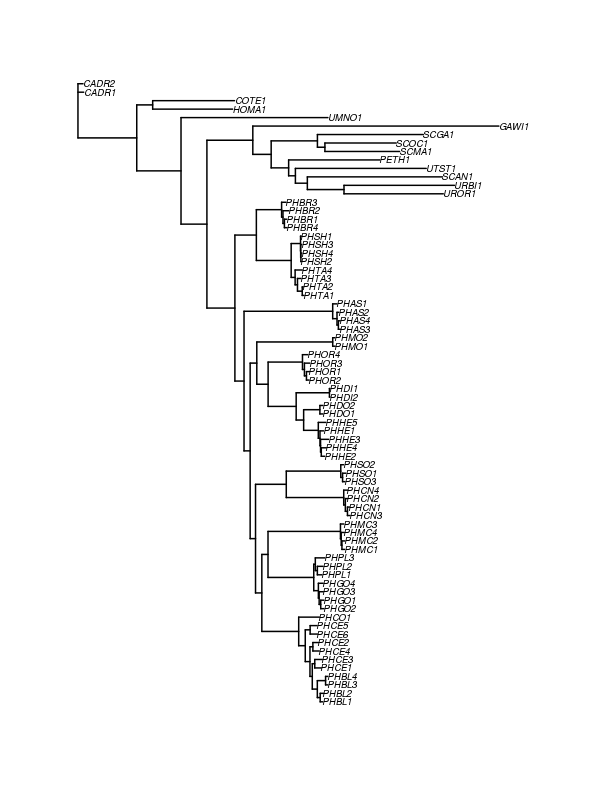

In [44]:
%%R -w 600 -h 800
library(ape)
tre <- read.tree("empirical_2/RAxML_bipartitions.empirical_2")
ltre <- ladderize(tre)
plot(ltre, cex=0.8, edge.width=2)
#nodelabels(ltre$node.label)

### Get average phylo distances (GTRgamma distance)

In [51]:
%%R
mean(cophenetic.phylo(ltre))

[1] 0.06260378
